In [98]:
from keras.models import Sequential
#Import from keras_preprocessing not from keras.preprocessing
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Rescaling, InputLayer
from keras.layers import Conv2D, MaxPooling2D, Conv3D
from tensorflow.keras.applications.vgg19 import preprocess_input, decode_predictions
from keras.utils import get_file, load_img, img_to_array
from keras.callbacks import ModelCheckpoint
from keras import regularizers, optimizers, Input
from IPython.display import Image, display
import pandas as pd
import numpy as np
from keras.optimizers import RMSprop, Adam
import ast
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
import os
import cv2
import re
import tensorflow as tf
from keras.applications import ResNet50, VGG19
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model
from keras.saving import load_model
import pickle

In [99]:
X_train = np.load('./Datasets/X_train.npy')
X_val = np.load('./Datasets/X_val.npy')
y_train = np.load('./Datasets/y_train.npy')
y_val = np.load('./Datasets/y_val.npy')
with open('./Datasets/class_weights.pkl', 'rb') as file:
    loaded_class_weights = pickle.load(file)

In [86]:
IMG_SHAPE = X_train[0].shape
IMG_SHAPE

(224, 224, 3)

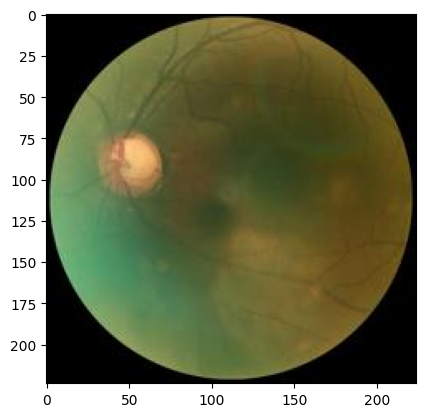

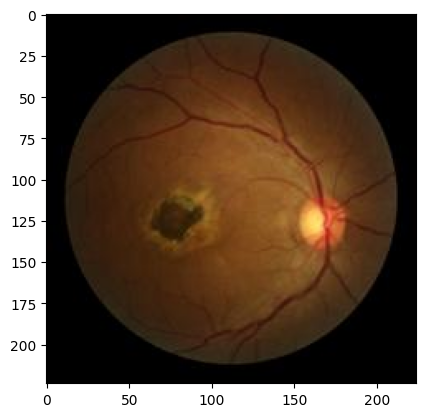

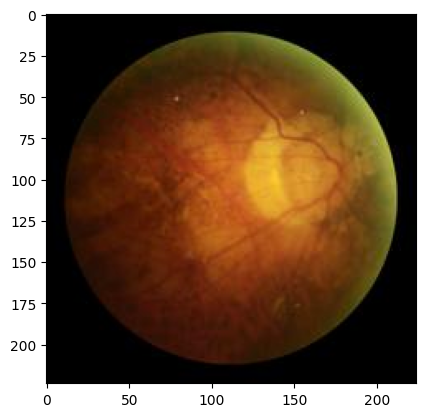

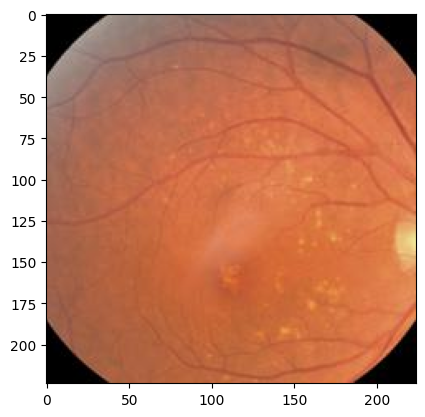

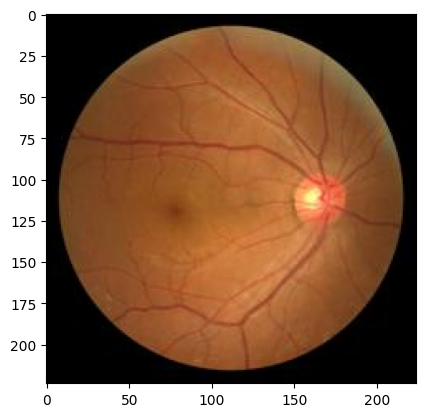

In [88]:
#plot X_train of augmented dataset
for i in range(5):
    plt.imshow(X_train[i])
    plt.show()

In [45]:
base_model = VGG19(include_top = False, weights = 'imagenet', input_shape = IMG_SHAPE)
base_model.trainable = False
model= Sequential()
model.add(InputLayer(input_shape = IMG_SHAPE))
model.add(base_model)
model.add(Flatten())
model.add(Dense(256,activation=('relu'))) 
model.add(Dropout(.2))
model.add(Dense(128,activation=('relu')))
model.add(Dropout(.2))
model.add(Dense(8,activation=('sigmoid')))

# Sanity check
print(f"\nModel input shape:\n{model.input_shape}\nModel output shape:\n"\
f"{model.output_shape}\n\n\nModel summary:") 
model.summary()


Model input shape:
(None, 224, 224, 3)
Model output shape:
(None, 8)


Model summary:
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_6 (Dense)             (None, 256)               6422784   
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                 

In [65]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

# For the Grad-CAM

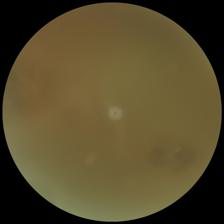

In [95]:
model_builder = VGG19
preprocess_input = preprocess_input
decode_predictions = decode_predictions

last_conv_layer_name = "block5_conv4"

# The local path to our target image
img_path = './squared_and_cropped_dataset/0_left_[0, 1, 0, 0, 0, 0, 0, 0].jpg'

display(Image(img_path))

In [96]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = Sequential(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [97]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=IMG_SHAPE))

# Make model
model = model_builder(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

1/1 [==============================] - 1s 623ms/step
Predicted: [('n04286575', 'spotlight', 9.266805)]


ValueError: name for name_scope must be a string.

# Back to the model

In [47]:
# Model is saved at the end of every epoch, if it's the best seen so far.
checkpoint_filepath = './Checkpointrun2'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [48]:
#Initializing the hyperparameters
batch_size= 2**6
initial_epochs=5 #15
learn_rate=0.001
adam = Adam(learning_rate=learn_rate)

In [49]:
class CustomDataGenerator(Sequence):
    def __init__(self, X, y, batch_size, class_weights):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.class_weights = class_weights

    def __len__(self):
        return int(np.ceil(len(self.X) / self.batch_size))

    def __getitem__(self, index):
        batch_X = self.X[index * self.batch_size:(index + 1) * self.batch_size]
        batch_y = self.y[index * self.batch_size:(index + 1) * self.batch_size]
        return batch_X, batch_y

    def on_epoch_end(self):
        # Optionally shuffle your data here
        pass

train_generator = CustomDataGenerator(X_train, y_train, batch_size, loaded_class_weights)

In [50]:

model.compile(optimizer=adam,loss='binary_crossentropy',metrics=[])

history = model.fit(train_generator,
                    epochs=initial_epochs,
                    validation_data=(X_val,y_val),
                    steps_per_epoch= 15, #len(X_train)/batch_size,
                    validation_steps=len(X_val),
                    callbacks=[model_checkpoint_callback],
                    verbose = 1)


Epoch 1/5
15/15 [==============================] - ETA: 0s - loss: 0.6935 - accuracy: 0.2990 INFO:tensorflow:Assets written to: ./Checkpointrun2/assets


INFO:tensorflow:Assets written to: ./Checkpointrun2/assets


15/15 [==============================] - 380s 26s/step - loss: 0.6935 - accuracy: 0.2990 - val_loss: 0.3722 - val_accuracy: 0.3983
Epoch 2/5
15/15 [==============================] - 371s 26s/step - loss: 0.4101 - accuracy: 0.3562 - val_loss: 0.3291 - val_accuracy: 0.3600
Epoch 3/5
15/15 [==============================] - 387s 27s/step - loss: 0.3594 - accuracy: 0.3323 - val_loss: 0.3248 - val_accuracy: 0.3983
Epoch 4/5
15/15 [==============================] - ETA: 0s - loss: 0.3423 - accuracy: 0.4115 INFO:tensorflow:Assets written to: ./Checkpointrun2/assets


INFO:tensorflow:Assets written to: ./Checkpointrun2/assets


15/15 [==============================] - 353s 24s/step - loss: 0.3423 - accuracy: 0.4115 - val_loss: 0.3185 - val_accuracy: 0.4089
Epoch 5/5
15/15 [==============================] - 356s 25s/step - loss: 0.3270 - accuracy: 0.4347 - val_loss: 0.3137 - val_accuracy: 0.4058


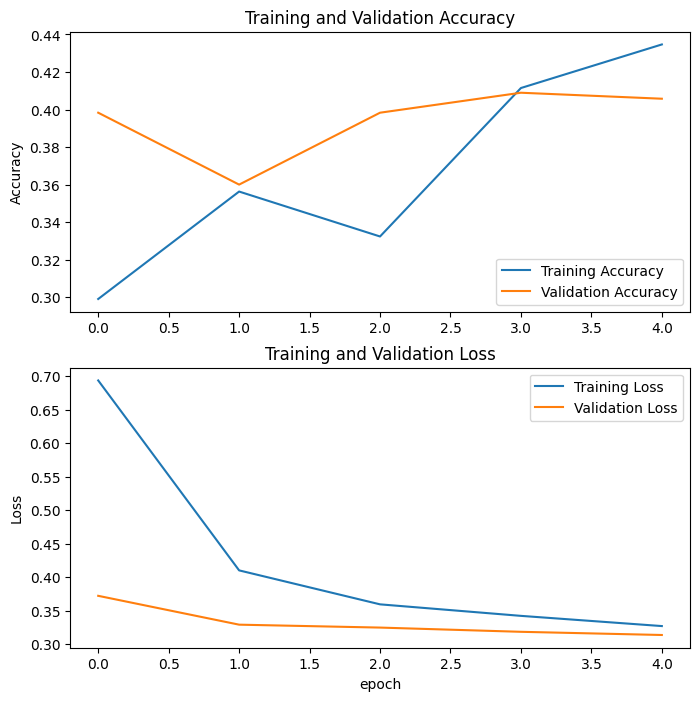

In [51]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# _ , accuracy = model.evaluate(x=X_test,y=y_test,batch_size= batch_size,verbose=1)
# print(f'Model accuracy on test set: {round(accuracy,3)*100}%')

In [22]:
testdfstart= pd.read_csv('XYZ_ODIR.csv')
testdfstart

,ID,N,D,G,C,A,H,M,O
0,937,0,0,0,0,0,0,0,0
1,967,0,0,0,0,0,0,0,0
2,988,0,0,0,0,0,0,0,0
3,995,0,0,0,0,0,0,0,0
4,1000,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
495,4787,0,0,0,0,0,0,0,0
496,4788,0,0,0,0,0,0,0,0
497,4789,0,0,0,0,0,0,0,0
498,4791,0,0,0,0,0,0,0,0


In [23]:
testdf = pd.DataFrame(np.repeat(testdfstart.values, 2, axis=0))
testdf.columns = testdfstart.columns

def append_extension(fn, side):
    return f"{fn}_{side}.jpg"

testdf['Side'] = testdf.index % 2

testdf['ID number'] = testdf.loc[:, 'ID']

testdf['ID number'] = testdf.apply(lambda row: append_extension(row['ID number'], 'left' if row['Side'] == 0 else 'right'), axis=1)

testdf.drop(columns=['Side'], inplace=True)

In [24]:
testdf = testdf[['ID', 'ID number', 'A', 'C', 'D', 'G', 'H', 'M', 'N', 'O']]

In [5]:
test_dir = './squared_and_cropped_dataset_test/'
test_img = [os.path.join(test_dir, i) for i in os.listdir(test_dir)]
img_size = 224

In [6]:
# Form the test labels
X_test = []
for image in tqdm(test_img):
    try:
        img = cv2.imread(image)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
            img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
            X_test.append(img)
    except:
        continue

100%|██████████| 1000/1000 [00:01<00:00, 724.79it/s]


In [10]:
X_test = np.asarray(X_test, dtype=np.float32)

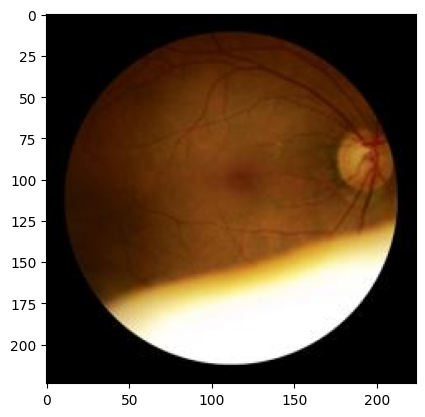

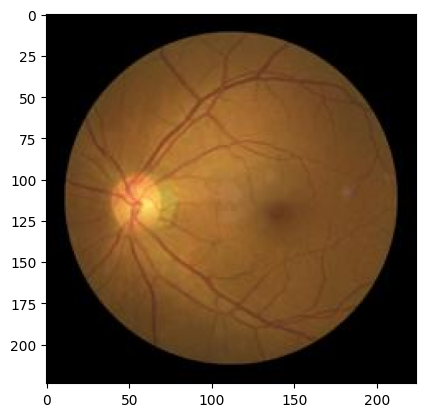

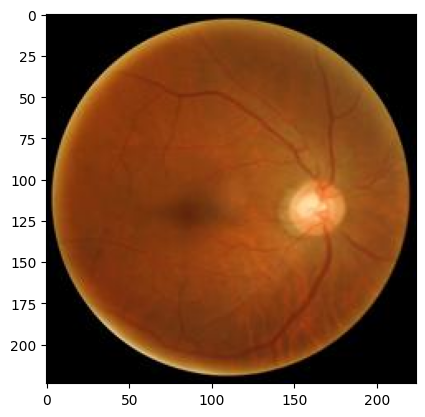

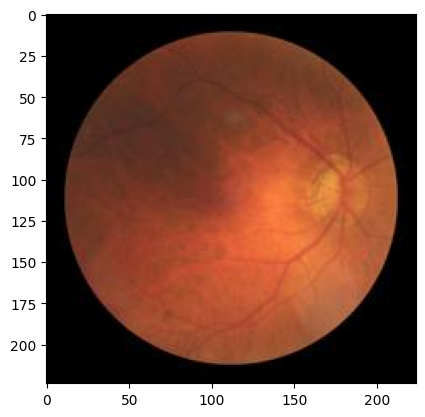

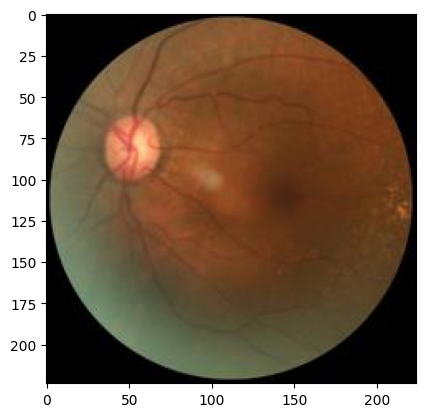

In [7]:
#plot X_train of augmented dataset
for i in range(5):
    plt.imshow(X_test[i])
    plt.show()

In [17]:
model = load_model('./Checkpointrun2/')
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_6 (Dense)             (None, 256)               6422784   
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dropout_5 (Dropout)         (None, 128)              

In [18]:
batch_size=2**6
# y_test = model.predict(X_test, steps=len(testdf)/batch_size)
y_test = model.predict(X_test, steps=15)

15/15 [==============================] - 188s 13s/step


In [25]:
for i,j in enumerate(['A', 'C', 'D', 'G', 'H', 'M', 'N', 'O']):
  testdf[j]=y_test[:,i]

In [26]:
# Weer de columns omzetten naar de juiste class volgorde om het in te leveren
testdf = testdf[['ID', 'ID number', 'N' ,'D' ,'G', 'C', 'A' ,'H' ,'M', 'O']]

In [27]:
# For each two rows, take the max of the two rows
testdf = testdf.groupby(testdf.index // 2).max()

In [28]:
testdf = testdf.drop(columns=['ID number'])

In [29]:
testdf

,ID,N,D,G,C,A,H,M,O
0,937,0.979835,0.921045,0.877196,0.647149,0.506162,0.466024,0.373134,0.859926
1,967,0.979842,0.921085,0.877262,0.647166,0.506113,0.466055,0.373068,0.859983
2,988,0.979856,0.921098,0.877303,0.647197,0.506017,0.466066,0.373081,0.860039
3,995,0.979842,0.921056,0.877228,0.647161,0.506049,0.466061,0.373104,0.859971
4,1000,0.979834,0.921054,0.877206,0.647137,0.506053,0.466042,0.373092,0.859931
...,...,...,...,...,...,...,...,...,...
495,4787,0.979855,0.921087,0.877248,0.647221,0.505987,0.466061,0.373077,0.859961
496,4788,0.979841,0.921060,0.877216,0.647183,0.506066,0.466040,0.373125,0.859924
497,4789,0.979846,0.921087,0.877299,0.647150,0.506067,0.466042,0.373097,0.860013
498,4791,0.979823,0.921027,0.877215,0.647139,0.506017,0.466057,0.373117,0.859950


In [54]:
testdf.to_csv('submissionnormalized.csv', index=False)

# Finetuning the model

In [55]:
model.trainable = True
print("The number of trainable variables in the model is:"
,len(model.trainable_variables))

The number of trainable variables in the model is: 38


In [56]:
#Initializing the hyperparameters
batch_size= 2**6
fine_tune_epochs=10
total_epochs =  initial_epochs + fine_tune_epochs
ft_learn_rate=0.00005
adam = Adam(learning_rate=ft_learn_rate)

model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])

history_fine = model.fit(train_generator,
                    epochs=total_epochs,
                    initial_epoch=history.epoch[-1],
                    validation_data=(X_val,y_val),
                    steps_per_epoch=len(X_train)/batch_size,
                    validation_steps=len(X_val),
                    callbacks=[model_checkpoint_callback],
                    verbose = 1)

Epoch 15/25
87/87 [==============================] - 3693s 42s/step - loss: 5.7640 - accuracy: 0.2951 - val_loss: 21.8115 - val_accuracy: 0.3983
Epoch 16/25
87/87 [==============================] - 3501s 40s/step - loss: 478.0634 - accuracy: 0.2778 - val_loss: 12290.4492 - val_accuracy: 0.3983
Epoch 17/25
87/87 [==============================] - 3250s 37s/step - loss: 1351360446464.0000 - accuracy: 0.2684 - val_loss: 10798562803712.0000 - val_accuracy: 0.3983
Epoch 18/25
87/87 [==============================] - 3387s 39s/step - loss: nan - accuracy: 0.1794 - val_loss: nan - val_accuracy: 0.0458
Epoch 19/25
87/87 [==============================] - 3199s 36s/step - loss: nan - accuracy: 0.0421 - val_loss: nan - val_accuracy: 0.0458
Epoch 20/25
87/87 [==============================] - 3264s 37s/step - loss: nan - accuracy: 0.0421 - val_loss: nan - val_accuracy: 0.0458
Epoch 21/25
87/87 [==============================] - 3100s 35s/step - loss: nan - accuracy: 0.0421 - val_loss: nan - val_a

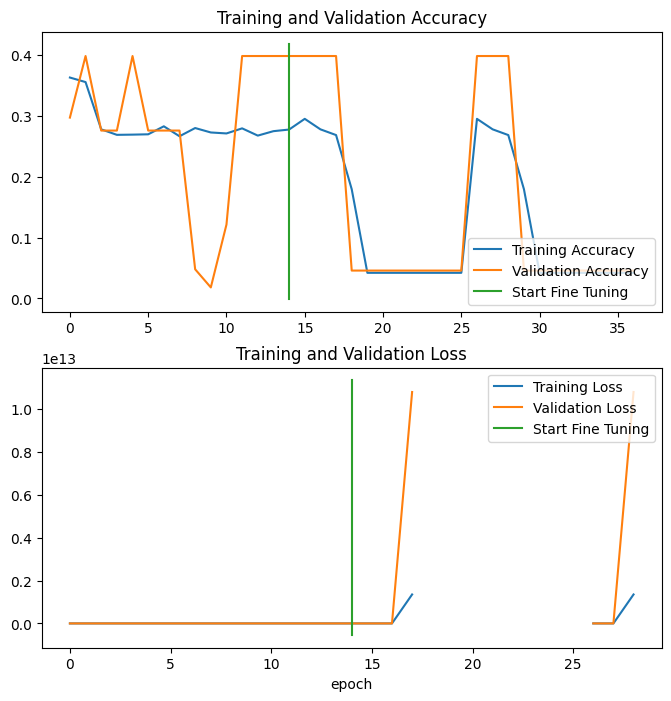

In [58]:
# Plotting the model performance after finetuning
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()
